# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
#The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding  to  a  total  of  79354  contacts.  During  these 
#phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. For each contact,  a  large  number  of  attributes  was  stored  (e.g.  see 
#Table  2)  and  if  there  was  a  success  (the  target  variable).For the whole database considered, there were 6499 successes (8% success rate). 

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [10]:
import pandas as pd
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [3]:
raw_url = 'https://github.com/nisheethg2000/UCB_AIML/raw/refs/heads/main/Practical%20Applications/Practical%20Application%20M17/data/bank-additional-full.zip'
bank_df = pd.read_csv(raw_url,compression = 'zip',sep=';')

In [4]:
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [5]:
bank_df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [6]:
def count_value_in_columns(df, value):
  """
  Counts the occurrences of a specific value in each column of a Pandas DataFrame.

  Args:
    df: The Pandas DataFrame.
    value: The value to count.

  Returns:
    A Pandas Series containing the counts of the value in each column, 
    indexed by column name.
  """
  return (df == value).sum()

In [7]:
value_to_count = 'unknown'
counts = count_value_in_columns(bank_df, value_to_count)
print(counts)

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64


In [8]:
bank_df.nunique()


age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64


Text(0, 0.5, 'success')

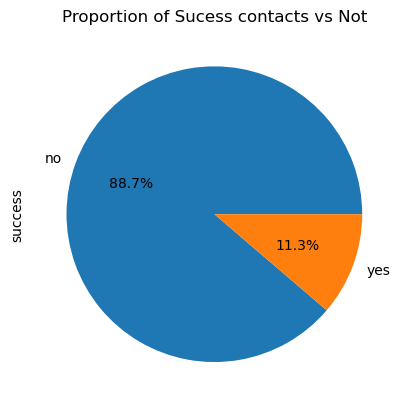

In [9]:
totalcontacts = bank_df['y'].value_counts(normalize=True)
print(totalcontacts)
#may be show a pie chart too
totalcontacts.plot.pie(autopct='%1.1f%%') 
plt.title("Proportion of Sucess contacts vs Not")
plt.ylabel("success")

Text(0.5, 1.0, 'Distribution of job with success')

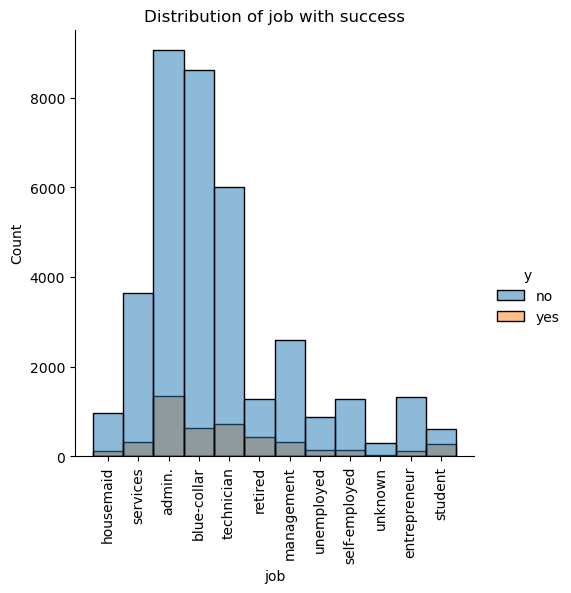

In [11]:
sns.displot(bank_df,x='job',hue='y')
plt.xticks(rotation=90)
plt.title('Distribution of job with success')

Text(0.5, 1.0, 'Distribution of education with success')

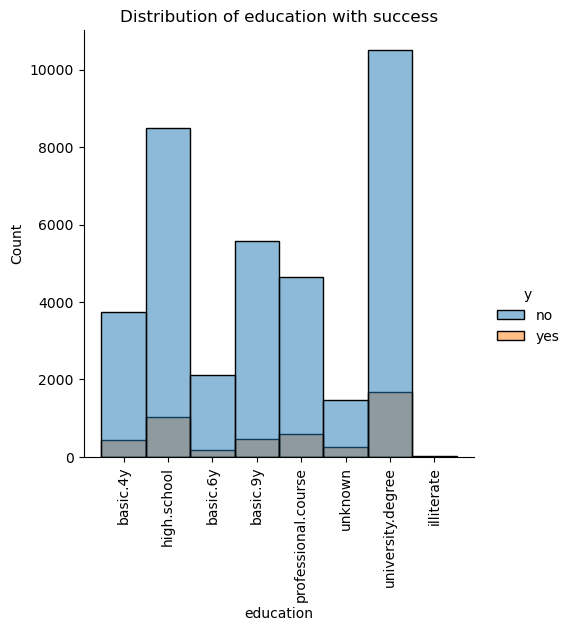

In [12]:
sns.displot(bank_df,x='education',hue='y')
plt.xticks(rotation=90)
plt.title('Distribution of education with success')

Text(0.5, 0, 'previous contact')

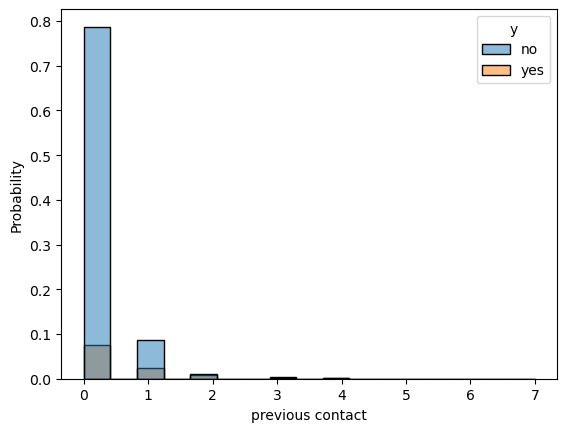

In [13]:
sns.histplot(data=bank_df, x='previous', hue='y',stat='probability',common_norm=True)
#data['temperature'].plot.hist(hue='temperature')
plt.xlabel('previous contact')

Text(0.5, 0, 'previous outcome contact')

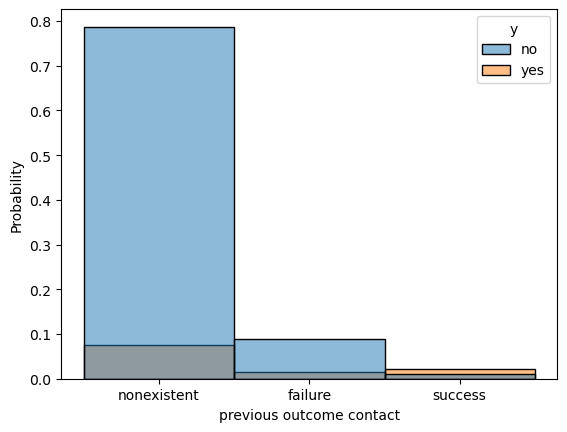

In [15]:
sns.histplot(data=bank_df, x='poutcome', hue='y',stat='probability',common_norm=True)
#data['temperature'].plot.hist(hue='temperature')
plt.xlabel('previous outcome contact')

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [11]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [9]:
#The  business  objective of the task is to find a model that can explain success of a contact by the marketing campaign, i.e. 
#if the client subscribes the term deposit.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [12]:
#create a data frame with out the target feature 'y'
X = bank_df.drop('y', axis=1)
y = bank_df.y

#using label encoder to encode target feature
le = LabelEncoder()
y = le.fit_transform(y)




In [13]:
#extracting categorical and numerical columns for proper encoding
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

#creating preprocessor for scaling numerical features and transforming cetgorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [15]:
#using linera regression model to create baseline performance
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('baseline_model', LinearRegression())
])

In [16]:
from sklearn.metrics import r2_score 
import time

In [17]:
results = []

In [18]:

start_time = time.time()
pipeline.fit(X_train, y_train)
fit_time = (time.time() - start_time)

predictions = pipeline.predict(X_test)
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)
results.append(['baseline_model', train_score, test_score, fit_time])
#Accuracy of the model
print(results)

[['baseline_model', 0.3586927390274288, 0.3539341387145917, 0.23701071739196777]]


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [19]:
#using Logistic regression model to test performance
pipeline_logistic = Pipeline([
    ('preprocessor', preprocessor),
    ('model_logistic', LogisticRegression(max_iter=1000))
])

In [20]:
start_time = time.time()
pipeline_logistic.fit(X_train, y_train)
fit_time = (time.time() - start_time)

Logistic_predictions = pipeline_logistic.predict(X_test)
train_score = pipeline_logistic.score(X_train, y_train)
test_score = pipeline_logistic.score(X_test, y_test)
results.append(['Logistic', train_score, test_score, fit_time])


### Problem 9: Score the Model

What is the accuracy of your model?

In [21]:
#Accuracy of the model
print(results)

[['baseline_model', 0.3586927390274288, 0.3539341387145917, 0.23701071739196777], ['Logistic', 0.9118361153262519, 0.911143481427531, 0.6125345230102539]]


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [22]:
# Define the models and hyperparameters
models = {
    'knnclassifier': (KNeighborsClassifier(), {'knnclassifier__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'svc': (SVC(), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [5, 10, 15]})
}

In [23]:
best_params_score= []

In [24]:

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1,scoring='accuracy')
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time)
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    #coef_list.append([name,list(best_model[1].coef_)])
    model_prediction = best_model.predict(X_test)
    # Evaluate on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    best_params_score.append([name, grid_search.best_params_,grid_search.best_score_])
    # Append the results
    results.append([name, train_score, test_score, fit_time])


In [25]:
# Create the results DataFrame
best_param_Score_df = pd.DataFrame(best_params_score, columns=['model', 'best_params', 'best_score'])
best_param_Score_df.set_index('model', inplace=True)

In [26]:
best_param_Score_df

,best_params,best_score
model,,
knnclassifier,{'knnclassifier__n_neighbors': 7},0.902215
logisticregression,{'logisticregression__C': 1},0.910926
svc,"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.911047
decisiontreeclassifier,{'decisiontreeclassifier__max_depth': 5},0.913657


In [27]:
# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['model', 'train score', 'test score', 'fit time'])
results_df.set_index('model', inplace=True)


In [28]:
results_df

,train score,test score,fit time
model,,,
baseline_model,0.358693,0.353934,0.237011
Logistic,0.911836,0.911143,0.612535
knnclassifier,0.924219,0.904467,10.221776
logisticregression,0.911836,0.911143,2.743608
svc,0.921700,0.911143,367.834974
decisiontreeclassifier,0.917420,0.915028,1.777854


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [29]:
improved_results=[]
best_params_score_improved= []

In [30]:
#dropping duration it is highly correlated and would affect the predictive model negatively
bank_df = bank_df.drop('duration',axis=1)

In [31]:
#create a data frame with out the target feature 'y'
X = bank_df.drop('y', axis=1)
y = bank_df.y

#using label encoder to encode target feature
le = LabelEncoder()
y = le.fit_transform(y)

In [32]:
#extracting categorical and numerical columns for proper encoding
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

#creating preprocessor for scaling numerical features and transforming cetgorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Using advanced params to see if the model performance improves further

In [ ]:
improved_models = {
    'knnclassifier': (KNeighborsClassifier(), {'knnclassifier__n_neighbors': list(range(1, 6, 2)),'knnclassifier__weights': ['uniform', 'distance'],
          'knnclassifier__p': [1, 2]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10],'logisticregression__multi_class':
                           ['ovr','multinomial']}),
    'svc': (SVC(), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['rbf', 'poly', 'linear'],'svc_gamma': ['scale', 'auto']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [None,5, 10, 15],
    'decisiontreeclassifier__min_samples_split': [2,5,10],'decisiontreeclassifier__min_samples_leaf': [1, 5, 10],
    'decisiontreeclassifier__criterion': ['gini', 'entropy']})
  
}

In [35]:
for name, (model, params) in improved_models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1,scoring='accuracy')
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time)
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    #coef_list.append([name,list(best_model[1].coef_)])
    model_prediction = best_model.predict(X_test)
    # Evaluate on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    best_params_score_improved.append([name, grid_search.best_params_,grid_search.best_score_])
    # Append the results
    improved_results.append([name, train_score, test_score, fit_time])

OSError: [WinError 1450] Insufficient system resources exist to complete the requested service

In [62]:
# Create the results DataFrame
best_param_Score_improved_df = pd.DataFrame(best_params_score_improved, columns=['model', 'best_params', 'best_score'])
best_param_Score_improved_df.set_index('model', inplace=True)

In [66]:
best_param_Score_improved_df

,best_params,best_score
model,,


In [64]:
# Create the results DataFrame
improved_results_df = pd.DataFrame(improved_results, columns=['model', 'train score', 'test score', 'fit time'])
improved_results_df.set_index('model', inplace=True)

In [67]:
improved_results_df

,train score,test score,fit time
model,,,
